In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('viridis')

## <center> -- The Data -- </center>

In [117]:
training_data = pd.read_csv('train.csv')
training_features = training_data.drop(['price_range'], axis=1)
training_target = training_data['price_range']

testing_data = pd.read_csv('test.csv')
testing_features = testing_data.drop(['id'], axis=1)

In [118]:
print(f'Training feature matrix has {training_features.shape[0]} rows and {training_features.shape[1]} columns')
print(f'Testing feature matrix has {testing_features.shape[0]} rows and {testing_features.shape[1]} columns')

Training feature matrix has 2000 rows and 20 columns
Testing feature matrix has 1000 rows and 20 columns


In [119]:
print(f'Number of features:\n\n{training_features.columns}')

Number of features:

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')


In [120]:
print(f'Target classes:\n\n{training_target.value_counts()}')

Target classes:

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64


In [121]:
is_any_null = any(training_data.isnull().sum(axis=0))
print(f'Is there any null values in training data? | {is_any_null}')

is_any_null_2 = any(testing_data.isnull().sum(axis=0))
print(f'Is there any null values in testing data? | {is_any_null_2}')

Is there any null values in training data? | False
Is there any null values in testing data? | False


In [122]:
is_any_duplicate = any(training_data.duplicated())
print(f'Is there any duplicate values in training data? | {is_any_duplicate}')

is_any_duplicate_2 = any(testing_data.duplicated())
print(f'Is there any duplicate values in testing data? | {is_any_duplicate_2}')

Is there any duplicate values in training data? | False
Is there any duplicate values in testing data? | False


## <center> -- Feature Ranges -- </center>

battery_power    1497.0
blue                1.0
clock_speed         2.5
dual_sim            1.0
fc                 19.0
four_g              1.0
int_memory         62.0
m_dep               0.9
mobile_wt         120.0
n_cores             7.0
pc                 20.0
px_height        1960.0
px_width         1498.0
ram              3742.0
sc_h               14.0
sc_w               18.0
talk_time          18.0
three_g             1.0
touch_screen        1.0
wifi                1.0
dtype: float64


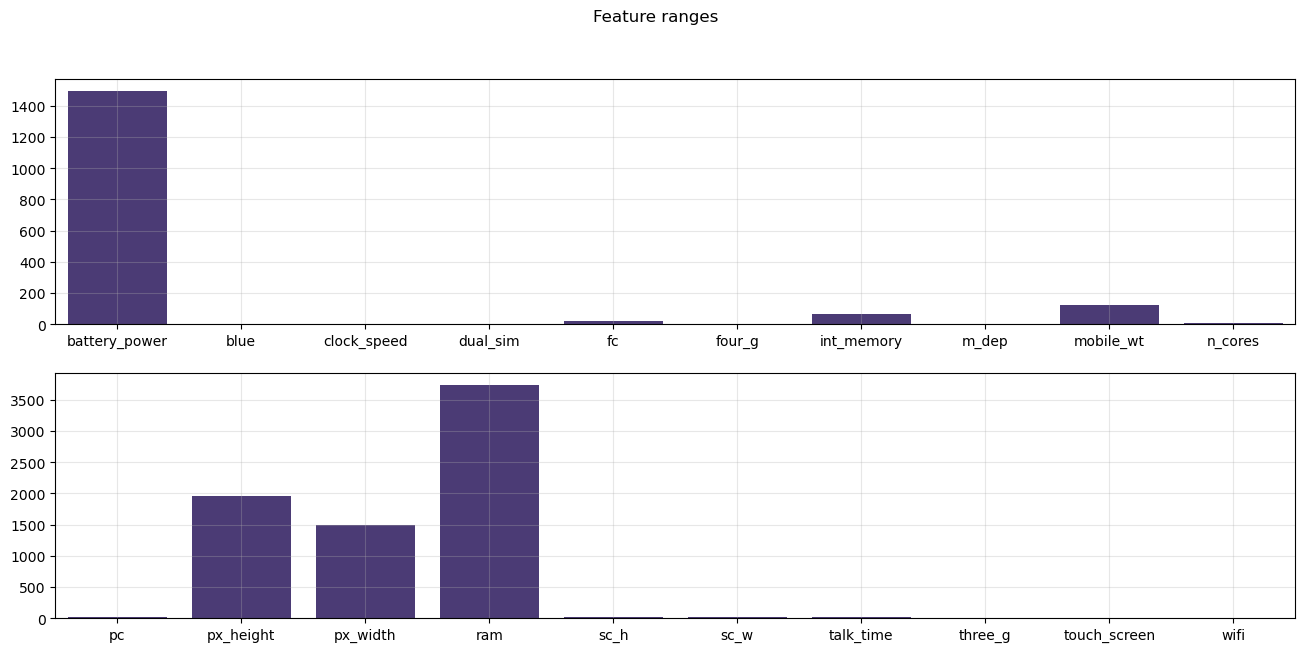

In [123]:
def calculate_ranges(column : np.ndarray):
    return column.max() - column.min()

feature_ranges = training_features.aggregate(calculate_ranges)

figure, axes = plt.subplots(2, 1, figsize=(16, 7))

sns.barplot(feature_ranges[:10], ax=axes[0])    # feature range for the first 10
sns.barplot(feature_ranges[10:], ax=axes[1])    # feature range for the last 10

figure.suptitle('Feature ranges')
axes[0].grid(alpha=0.3)
axes[1].grid(alpha=0.3)

print(feature_ranges)

* We see the ranges of the features vary wildly.
* The `battery power`, `px_height`, `px_width` and `ram` seem like continous features.
* The remaining features seem like categorical features
    * Categorical features can be nominal or ordinal:
        * Nominal features are ones where the order doesn't mean anything
        * Ordinal features are ones where the order matter
    * Features like `n_cores` are ordinal (more cpu cores in a phone are better)
    * Features like `wifi` if it's represented as 1 or 0 are ordinal values
* I need to get a close look at these values that are not clearly continuous

## <center> Categorical features </center>

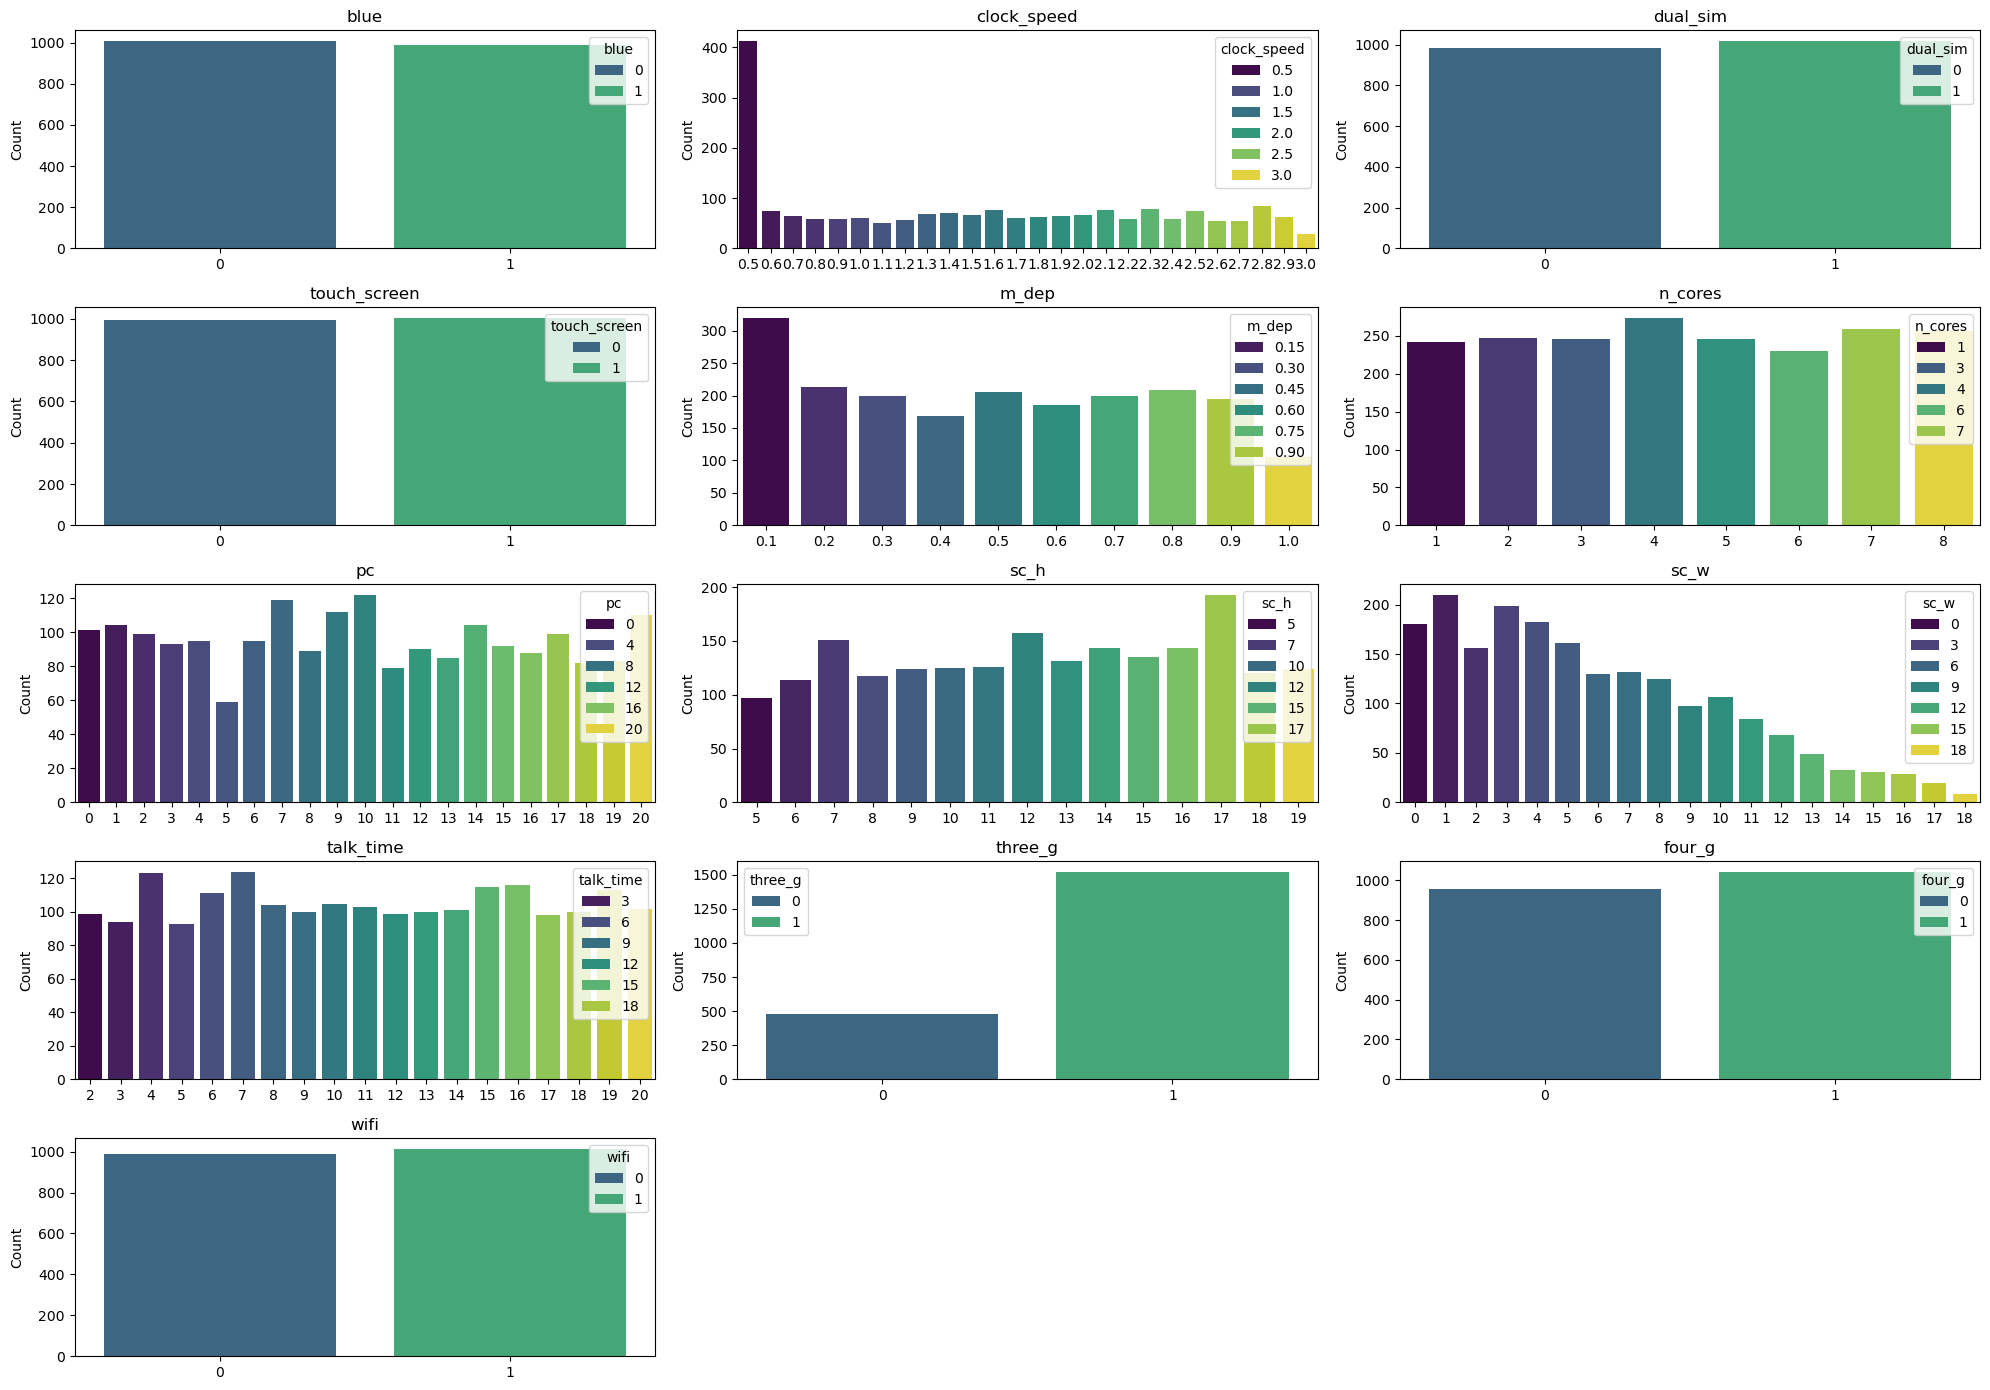

In [124]:
categorical_features = ['blue', 'clock_speed', 'dual_sim', 'touch_screen', 'm_dep', 
                    'n_cores', 'pc', 'sc_h', 'sc_w', 'talk_time', 
                    'three_g', 'four_g', 'wifi']

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 14))
axes = axes.flatten()

for i, column in enumerate(categorical_features):
    counts = training_features[column].value_counts()  # a series where the index is the value names are the values are the number of times it's in the data
    sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette='viridis', hue=counts.index)
    axes[i].set_title(column)
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel("")   # the x=counts.index in the barplot will assign the x axis labels to the names of the values(digits)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

Continuous features are: ['battery_power', 'fc', 'int_memory', 'mobile_wt', 'px_height', 'px_width', 'ram']
There are 7 continuous features


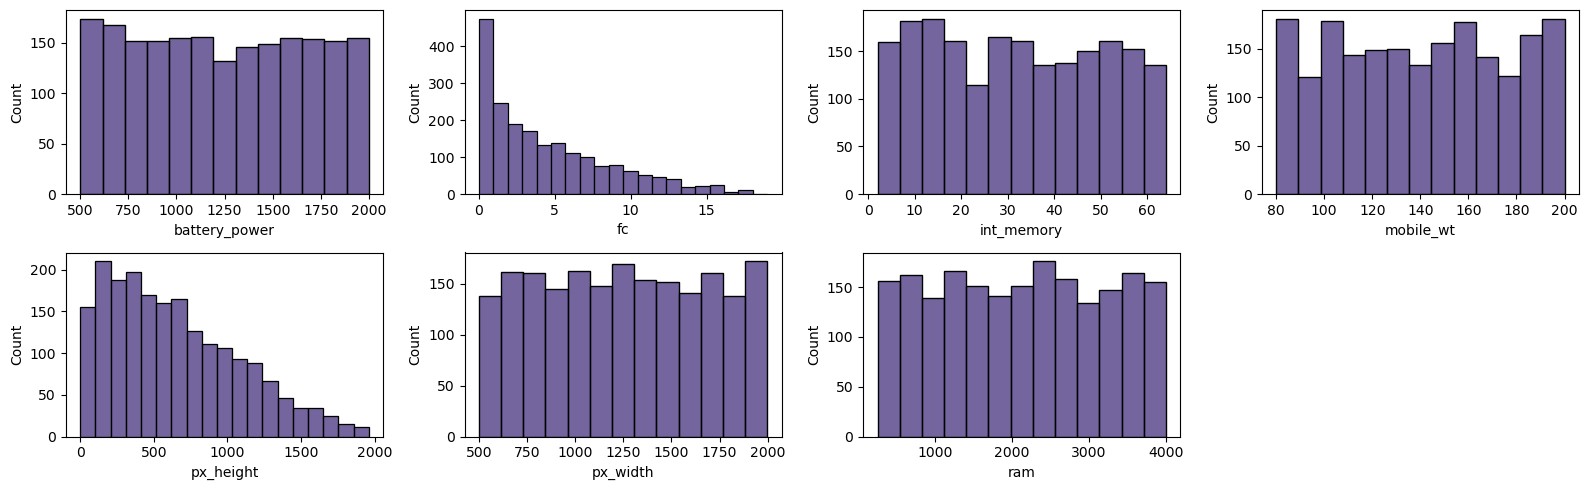

In [125]:
continuous_features = [column for column in training_features.columns if column not in categorical_features]
print(f'Continuous features are: {continuous_features}')
print(f'There are {len(continuous_features)} continuous features')

figure, axes = plt.subplots(2, 4, figsize=(16,5))
axes = axes.flatten()

for index, column in enumerate(continuous_features):
    sns.histplot(training_features[column], ax=axes[index])

figure.delaxes(axes[index + 1])

figure.tight_layout()

## <center> Feature Correlation </center>

<Axes: >

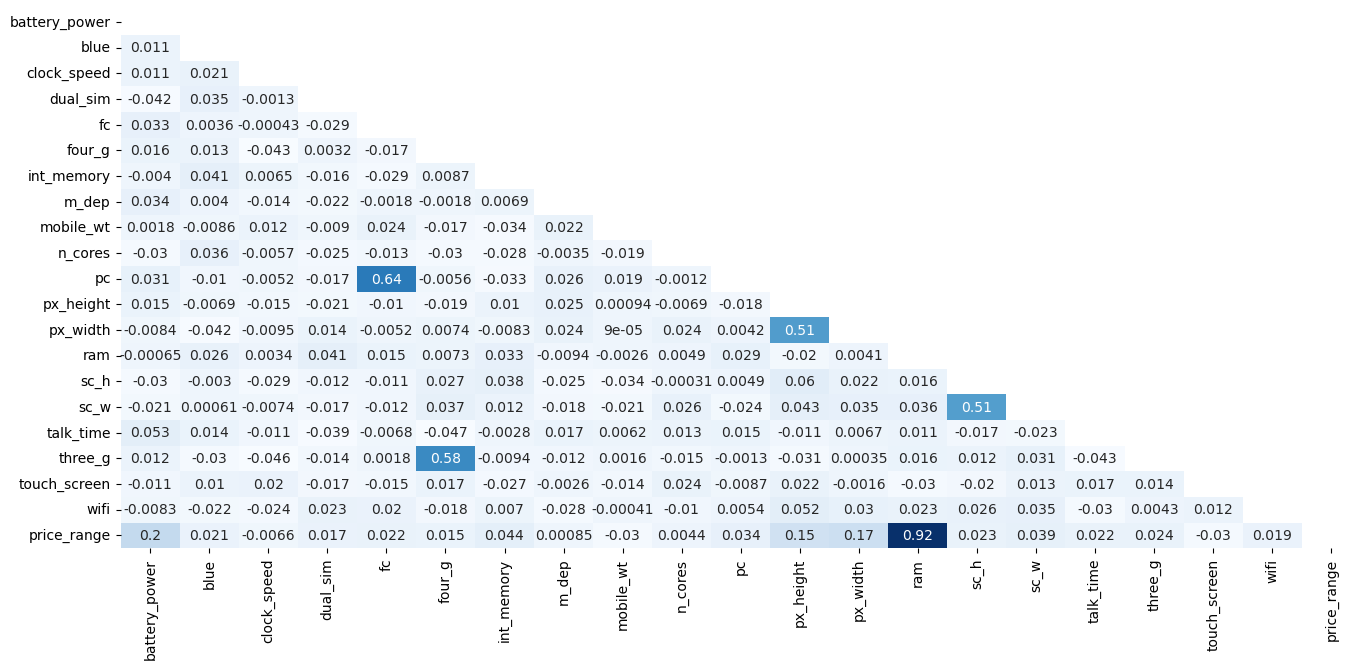

In [126]:
correlation_matrix = training_data.corr()

plt.figure(figsize=(16, 7))
sns.heatmap(correlation_matrix, mask=np.triu(correlation_matrix), annot=True, cmap='Blues', cbar=False)

<Axes: xlabel='ram', ylabel='battery_power'>

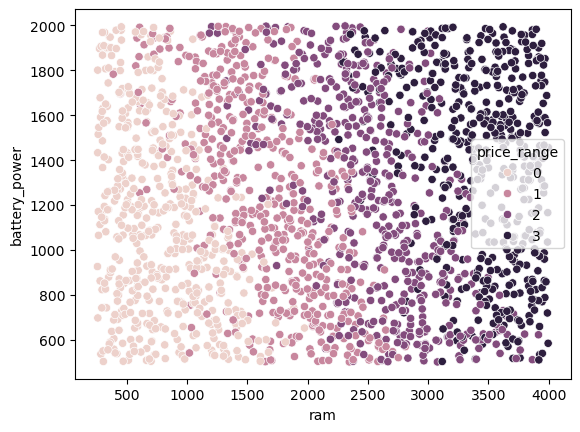

In [127]:
sns.scatterplot(data=training_data, x='ram', y='battery_power', hue='price_range')
# sns.scatterplot(data=training_data, x='ram', y='price_range', hue='price_range')

## <center> Model </center>

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

training_features_array = np.asarray(training_features)
training_target_array   = np.asarray(training_target)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

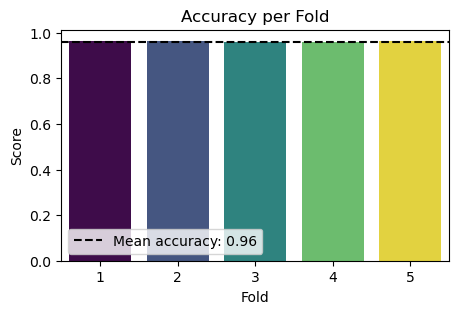

In [ ]:
n_folds = 5
skfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(pipe, training_features_array, training_target_array, cv=skfold, scoring='accuracy')

figure, ax = plt.subplots(1, 1, figsize=(5, 3))

sns.barplot(x=range(1, n_folds + 1), y=accuracy_scores, palette='viridis', hue=range(n_folds), legend=False, ax=ax)
ax.axhline(y=np.mean(accuracy_scores), linestyle='--', color='black', label=f'Mean accuracy: {np.mean(accuracy_scores):.2f}')

ax.set_xlabel('Fold')
ax.set_ylabel('Score')
ax.set_title('Accuracy per Fold')
ax.legend();

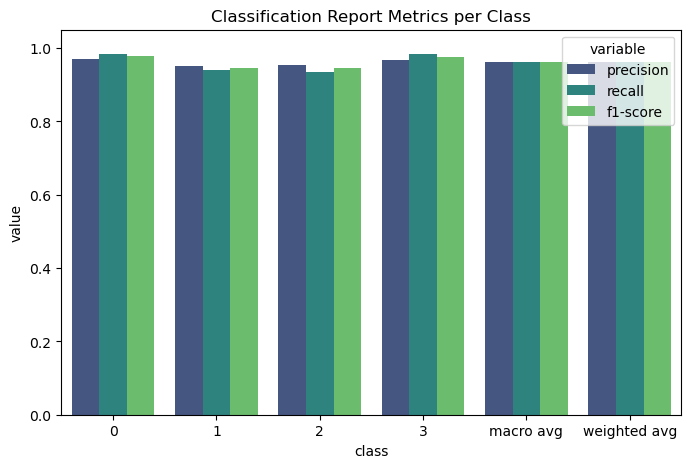

In [139]:
predictions = cross_val_predict(pipe, training_features_array, training_target_array, cv=skfold)

# Example: classification report
report_dict = classification_report(training_target, predictions, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Drop 'accuracy' row (it’s a single scalar, not per-class metric)
report_df = report_df.drop(index='accuracy')

# Optional: reset index for plotting
report_df = report_df.reset_index().rename(columns={'index': 'class'})

# Example plot: precision, recall, and f1-score
plt.figure(figsize=(8, 5))

report_melted = report_df.melt(id_vars='class', value_vars=['precision', 'recall', 'f1-score'])
sns.barplot(data=report_melted, x='class', y='value', hue='variable', palette='viridis')

plt.ylim(0, 1.05)
plt.title('Classification Report Metrics per Class');

In [130]:
pipe.fit(training_features_array, training_target_array)
predictions = pipe.predict(np.asarray(testing_features))